# Sequence-to-Sequence Model with Attention

Seq2seq models are used for applications such as machine translation and image caption generation.

We will build a seq2seq model with attention in PyTorch for translating English to French.

- [Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/): A great blog post to learn seq2seq model with attention wth visual explanations.

In [1]:
import itertools
from collections import Counter
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk import wordpunct_tokenize
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from tqdm import tqdm_notebook, tqdm
from preprocessing_task_2 import prepare_data


In order to perform deep learning on a GPU (so that everything runs super quick!), CUDA has to be installed and configured. Fortunately, Google Colab already has this set up, but if you want to try this on your own GPU, you can [install CUDA from here](https://developer.nvidia.com/cuda-downloads). Make sure you also [install cuDNN](https://developer.nvidia.com/cudnn) for optimized performance.

In [2]:
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')

device

device(type='cpu')

## Download the data

We will download a dataset of English-to-French translations from a public Google Drive folder.

In [3]:
def tokenize(text):
    """Turn text into discrete tokens.

    Remove tokens that are not words.
    """
    text = str(text).lower()
    tokens = wordpunct_tokenize(text)

    # Only keep words
    tokens = [token for token in tokens
              if all(char.isalpha() for char in token)]

    return tokens


class EnglishFrenchTranslations(Dataset):
    #def __init__(self, path, max_vocab):
    def __init__(self, df, max_vocab):
    
        self.max_vocab = max_vocab
        
        # Extra tokens to add
        self.padding_token = '<PAD>'
        self.start_of_sequence_token = '<SOS>'
        self.end_of_sequence_token = '<EOS>'
        self.unknown_word_token = '<UNK>'
        
        # Helper function
        self.flatten = lambda x: [sublst for lst in x for sublst in lst]
        
        # Load the data into a DataFrame
        #df = pd.read_csv(path, names=['english', 'french'], sep='|')
        print(df.head())
        # Tokenize inputs (English) and targets (French)
        self.tokenize_df(df)

        # To reduce computational complexity, replace rare words with <UNK>
        self.replace_rare_tokens(df)
        
        # Prepare variables with mappings of tokens to indices
        self.create_token2idx(df)
        
        # Remove sequences with mostly <UNK>
        df = self.remove_mostly_unk(df)
        
        # Every sequence (input and target) should start with <SOS>
        # and end with <EOS>
        self.add_start_and_end_to_tokens(df)
        
        # Convert tokens to indices
        self.tokens_to_indices(df)
        
    def __getitem__(self, idx):
        """Return example at index idx."""
        return self.indices_pairs[idx][0], self.indices_pairs[idx][1]
    
    def tokenize_df(self, df):
        """Turn inputs and targets into tokens."""
        df['tokens_inputs'] = df.english.apply(tokenize)
        df['tokens_targets'] = df.french.apply(tokenize)
        
    def replace_rare_tokens(self, df):
        """Replace rare tokens with <UNK>."""
        common_tokens_inputs = self.get_most_common_tokens(
            df.tokens_inputs.tolist(),
        )
        common_tokens_targets = self.get_most_common_tokens(
            df.tokens_targets.tolist(),
        )
        
        df.loc[:, 'tokens_inputs'] = df.tokens_inputs.apply(
            lambda tokens: [token if token in common_tokens_inputs 
                            else self.unknown_word_token for token in tokens]
        )
        df.loc[:, 'tokens_targets'] = df.tokens_targets.apply(
            lambda tokens: [token if token in common_tokens_targets
                            else self.unknown_word_token for token in tokens]
        )

    def get_most_common_tokens(self, tokens_series):
        """Return the max_vocab most common tokens."""
        all_tokens = self.flatten(tokens_series)
        # Substract 4 for <PAD>, <SOS>, <EOS>, and <UNK>
        common_tokens = set(list(zip(*Counter(all_tokens).most_common(
            self.max_vocab - 4)))[0])
        return common_tokens

    def remove_mostly_unk(self, df, threshold=0.99):
        """Remove sequences with mostly <UNK>."""
        def calculate_ratio(tokens):
            # Check if tokens list is empty to avoid division by zero
            if len(tokens) == 0:
                return False  # Consider returning True if you want to remove empty token lists
            return (sum(1 for token in tokens if token != '<UNK>') / len(tokens)) > threshold

        # Apply the function to the DataFrame columns
        df = df[df['tokens_inputs'].apply(calculate_ratio)]
        df = df[df['tokens_targets'].apply(calculate_ratio)]
        return df

    def create_token2idx(self, df):
        """Create variables with mappings from tokens to indices."""
        unique_tokens_inputs = set(self.flatten(df.tokens_inputs))
        unique_tokens_targets = set(self.flatten(df.tokens_targets))
        
        for token in reversed([
            self.padding_token,
            self.start_of_sequence_token,
            self.end_of_sequence_token,
            self.unknown_word_token,
        ]):
            if token in unique_tokens_inputs:
                unique_tokens_inputs.remove(token)
            if token in unique_tokens_targets:
                unique_tokens_targets.remove(token)
                
        unique_tokens_inputs = sorted(list(unique_tokens_inputs))
        unique_tokens_targets = sorted(list(unique_tokens_targets))

        # Add <PAD>, <SOS>, <EOS>, and <UNK> tokens
        for token in reversed([
            self.padding_token,
            self.start_of_sequence_token,
            self.end_of_sequence_token,
            self.unknown_word_token,
        ]):
            
            unique_tokens_inputs = [token] + unique_tokens_inputs
            unique_tokens_targets = [token] + unique_tokens_targets
            
        self.token2idx_inputs = {token: idx for idx, token
                                 in enumerate(unique_tokens_inputs)}
        self.idx2token_inputs = {idx: token for token, idx
                                 in self.token2idx_inputs.items()}
        
        self.token2idx_targets = {token: idx for idx, token
                                  in enumerate(unique_tokens_targets)}
        self.idx2token_targets = {idx: token for token, idx
                                  in self.token2idx_targets.items()}
        
    def add_start_and_end_to_tokens(self, df):
        """Add <SOS> and <EOS> tokens to the end of every input and output."""
        df['tokens_inputs'] = df['tokens_inputs'].apply(
            lambda tokens: [self.start_of_sequence_token] + tokens + [self.end_of_sequence_token]
        )
        df['tokens_targets'] = df['tokens_targets'].apply(
            lambda tokens: [self.start_of_sequence_token] + tokens + [self.end_of_sequence_token]
        )
        
    def tokens_to_indices(self, df):
        """Convert tokens to indices."""
        df['indices_inputs'] = df.tokens_inputs.apply(
            lambda tokens: [self.token2idx_inputs[token] for token in tokens])
        df['indices_targets'] = df.tokens_targets.apply(
            lambda tokens: [self.token2idx_targets[token] for token in tokens])
             
        self.indices_pairs = list(zip(df.indices_inputs, df.indices_targets))
        
    def __len__(self):
        return len(self.indices_pairs)

In [19]:
def read_file(file_path,fraction):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.readlines()  # reads all lines into a list
        
    # Remove newline characters at the end of each line
    content = [line.strip() for line in content]
    
    # Calculate the number of lines to return based on the fraction
    if 0 < fraction < 1:
        end_index = int(len(content) * fraction)
        return content[:end_index]
    else:
        return content[:fraction]  # Return the full list



In [20]:
#### TRANSFORM OUR DATA IN THE DESIRED FORMAT#########

In [21]:
max_words = 5
fraction = 20000000
english_file_path = "fr-en/europarl-v7.fr-en.en"
french_file_path = "fr-en/europarl-v7.fr-en.fr"

# Assuming read_file function is correctly implemented and returns the data needed
english_data = read_file(english_file_path, fraction)
french_data = read_file(french_file_path, fraction)


In [23]:
# Creating new lists that only include entries with <= max_words
max_words = 5  # Setting the max words limit, as per your example
filtered_english_data = []
filtered_french_data = []

for en, fr in zip(english_data, french_data):
    word_en = en.split(" ")
    word_fr = fr.split(" ")
    if len(word_en) <= max_words and len(word_fr) <= max_words:
        filtered_english_data.append(en)
        filtered_french_data.append(fr)

print(len(filtered_english_data))
    


56641


In [24]:
df = pd.DataFrame({
    'english': filtered_english_data,
    'french': filtered_french_data
})

dataset = EnglishFrenchTranslations(df, max_vocab=2000)

len(dataset)

                         english                            french
0      Resumption of the session             Reprise de la session
1                         Agenda                 Ordre des travaux
2  (Applause from the PSE Group)  (Applaudissements du groupe PSE)
3      Thank you, Mr Poettering.        Merci Monsieur Poettering.
4           Thank you very much.                            Merci.


36955

In [25]:
i = 4201
print(df["english"][i])
print(df["french"][i])

Environmental policy
Politique de l'environnement


### Create data generators using `DataLoader`

In [476]:
def collate(batch):
    inputs = [torch.LongTensor(item[0]) for item in batch]
    targets = [torch.LongTensor(item[1]) for item in batch]
    
    # Pad sequencse so that they are all the same length (within one minibatch)
    padded_inputs = pad_sequence(inputs, padding_value=dataset.token2idx_targets[dataset.padding_token], batch_first=True)
    padded_targets = pad_sequence(targets, padding_value=dataset.token2idx_targets[dataset.padding_token], batch_first=True)
    
    # Sort by length for CUDA optimizations
    lengths = torch.LongTensor([len(x) for x in inputs])
    lengths, permutation = lengths.sort(dim=0, descending=True)

    return padded_inputs[permutation].to(device), padded_targets[permutation].to(device), lengths.to(device)




## Seq2Seq with Attention

![](images/seq2seq_high_level.png)

![](images/attention_details.png)
[source](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)

### Define the Encoder

In [477]:
"""class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(
            self.embedding_dim,
            self.hidden_size,
            batch_first=True,
        )"""

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, batch_size, pretrained_embeddings):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Set pretrained weights
        self.embedding.weight.requires_grad = True  # Optionally, make embeddings trainable
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, batch_first=True)
    
    # Remaining methods remain unchanged
        
    def forward(self, inputs, lengths):
        self.batch_size = inputs.size(0)
        
        # Turn input indices into distributed embeddings
        x = self.embedding(inputs)

        # Remove padding for more efficient RNN application
        x = pack_padded_sequence(x, lengths, batch_first=True)
    
        # Apply RNN to get hidden state at all timesteps (output)
        # and hidden state of last output (self.hidden)
        output, self.hidden = self.gru(x, self.init_hidden())
        
        # Pad the sequences like they were before
        output, _ = pad_packed_sequence(output)
        
        return output, self.hidden

    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn(1, self.batch_size, self.hidden_size).to(device)

### Define the Decoder

In [478]:
"""class Decoder(nn.Module):
    def __init__(
        self, 
        vocab_size,
        embedding_dim, 
        decoder_hidden_size,
        encoder_hidden_size, 
        batch_size,
    ):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(
            self.embedding_dim + self.encoder_hidden_size, 
            self.decoder_hidden_size,
            batch_first=True,
        )
        self.fc = nn.Linear(self.encoder_hidden_size, self.vocab_size)"""

class Decoder(nn.Module):
    def __init__(
        self, 
        vocab_size,
        embedding_dim, 
        decoder_hidden_size,
        encoder_hidden_size, 
        batch_size,
        pretrained_embeddings
    ):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Set pretrained weights
        self.embedding.weight.requires_grad = True  # Optionally, make embeddings trainable
        self.gru = nn.GRU(
            self.embedding_dim + self.encoder_hidden_size, 
            self.decoder_hidden_size,
            batch_first=True,
        )
        self.fc = nn.Linear(self.encoder_hidden_size, self.vocab_size)
        
        # Attention weights
        self.W1 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.W2 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.V = nn.Linear(self.encoder_hidden_size, 1)
    
    def forward(self, targets, hidden, encoder_output):
        self.batch_size = inputs.size(0)
        
        # Switch the dimensions of sequence_length and batch_size
        encoder_output = encoder_output.permute(1, 0, 2)

        # Add an extra axis for a time dimension
        hidden_with_time_axis = hidden.permute(1, 0, 2)
        
        # Attention score (Bahdanaus)
        score = torch.tanh(self.W1(encoder_output) + self.W2(hidden_with_time_axis))

        # Attention weights
        attention_weights = torch.softmax(self.V(score), dim=1)
        
        # Find the context vectors
        context_vector = attention_weights * encoder_output
        context_vector = torch.sum(context_vector, dim=1)
        
        # Turn target indices into distributed embeddings
        x = self.embedding(targets)
        
        # Add the context representation to the target embeddings
        x = torch.cat((context_vector.unsqueeze(1), x), -1)
        
        # Apply the RNN
        output, state = self.gru(x, self.init_hidden())
        
        # Reshape the hidden states (output)
        output = output.view(-1, output.size(2))
        
        # Apply a linear layer
        x = self.fc(output)
        
        return x, state, attention_weights
    
    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn(1, self.batch_size, self.decoder_hidden_size).to(device)

### Define a model that has both an Encoder and Decoder

In [493]:
criterion = nn.CrossEntropyLoss()

def loss_function(real, pred):
    """Calculate how wrong the model is."""
    # Use mask to only consider non-zero inputs in the loss
    mask = real.ge(1).float().to(device)
    
    loss_ = criterion(pred, real) * mask 
    return torch.mean(loss_)


"""class EncoderDecoder(nn.Module):
    def __init__(self, inputs_vocab_size, targets_vocab_size, hidden_size,
                 embedding_dim, batch_size, targets_start_idx, targets_stop_idx):
        super(EncoderDecoder, self).__init__()
        self.batch_size = batch_size
        self.targets_start_idx = targets_start_idx
        self.targets_stop_idx = targets_stop_idx
        
        self.encoder = Encoder(inputs_vocab_size, embedding_dim,
                               hidden_size, batch_size).to(device)
        
        self.decoder = Decoder(targets_vocab_size, embedding_dim,
                               hidden_size, hidden_size, batch_size).to(device)"""

class EncoderDecoder(nn.Module):
    def __init__(self, inputs_vocab_size, targets_vocab_size, hidden_size,
                 embedding_dim, batch_size, targets_start_idx, targets_stop_idx,
                 encoder_embeddings, decoder_embeddings):  # Added embeddings parameters
        super(EncoderDecoder, self).__init__()
        self.batch_size = batch_size
        self.targets_start_idx = targets_start_idx
        self.targets_stop_idx = targets_stop_idx
        
        # Pass pretrained embeddings to the encoder and decoder
        self.encoder = Encoder(inputs_vocab_size, embedding_dim,
                               hidden_size, batch_size, encoder_embeddings).to(device)
        
        self.decoder = Decoder(targets_vocab_size, embedding_dim,
                               hidden_size, hidden_size, batch_size, decoder_embeddings).to(device)
        
        
    def predict(self, inputs, lengths):
        self.batch_size = inputs.size(0)
        
        encoder_output, encoder_hidden = self.encoder(
            inputs.to(device),
            lengths,
        )
        decoder_hidden = encoder_hidden

        
        # Initialize the input of the decoder to be <SOS>
        decoder_input = torch.LongTensor(
            [[self.targets_start_idx]] * self.batch_size,
        )
        
        # Output predictions instead of loss
        output = []
        attention_matrix = [] #ADDED FOR A

        for _ in range(20): #max sequence length, since we work with short sentences
            #predictions, decoder_hidden, _ = self.decoder( 
            predictions, decoder_hidden, attention_weights = self.decoder( #ADDED FOR A
                decoder_input.to(device), 
                decoder_hidden.to(device),
                encoder_output.to(device),
                )
           
            prediction = torch.multinomial(F.softmax(predictions, dim=1), 1)
            decoder_input = prediction

            prediction = prediction.item()
            output.append(prediction)
            attention_matrix.append(attention_weights.cpu().numpy())


            if prediction == self.targets_stop_idx:
                return output,  np.stack(attention_matrix)

        #return output
        return output, np.stack(attention_matrix) #ADDED FOR A

    def forward(self, inputs, targets, lengths):
        self.batch_size = inputs.size(0)
        
        encoder_output, encoder_hidden = self.encoder(
            inputs.to(device),
            #lengths,
            lengths.cpu(), #CHANGE
        )
        decoder_hidden = encoder_hidden
        
        # Initialize the input of the decoder to be <SOS>
        decoder_input = torch.LongTensor(
            [[self.targets_start_idx]] * self.batch_size,
        )
                
        # Use teacher forcing to train the model. Instead of feeding the model's
        # own predictions to itself, feed the target token at every timestep.
        # This leads to faster convergence
        loss = 0
        for timestep in range(1, targets.size(1)):
            predictions, decoder_hidden, _ = self.decoder(
                decoder_input.to(device), 
                decoder_hidden.to(device),
                encoder_output.to(device),
            )
            decoder_input = targets[:, timestep].unsqueeze(1)
            
            loss += loss_function(targets[:, timestep], predictions)
            
        return loss / targets.size(1)

In [494]:
from typing import Dict
# Example GloVe embedding file path and embedding dimension

def load_glove_embeddings(path: str, word2idx: Dict[str, int], embedding_dim: int) -> torch.Tensor:
    """
    Load GloVe embeddings from a specified file and align them with the given word index dictionary.

    Parameters:
    - path (str): The file path to the GloVe embeddings file.
    - word2idx (Dict[str, int]): A dictionary mapping words to their corresponding indices. This dictionary defines
      the position each word’s vector should occupy in the resulting embedding matrix.
    - embedding_dim (int): The dimensionality of the GloVe vectors (e.g., 50, 100, 200, 300).

    Returns:
    - torch.Tensor: A tensor of shape (len(word2idx), embedding_dim) containing the GloVe vectors aligned according to word2idx.
    """
    with open(path, 'r', encoding='utf-8') as f:
        # Initialize the embedding matrix with zeros
        #embeddings = np.zeros((len(word2idx), embedding_dim))
        #better approach: init with random 
        embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))
        # Process each line in the GloVe file
        for line in f:
            values = line.split()
            word = values[0]
            
            # If the word is in the provided dictionary, update the corresponding row in embeddings
            if word in word2idx.keys():
                # Convert embedding values from strings to float32
                vector = np.asarray(values[1:], dtype='float32')
                # Place the vector in the correct index as per word2idx
                embeddings[word2idx[word]] = vector
            else:
                pass
    # Convert the numpy array to a PyTorch tensor
    return torch.from_numpy(embeddings)



def load_word2vec_embeddings(path, word2idx, embedding_dim):
    embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))
    with open(path, 'r', encoding='latin1') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word2idx:
                try:
                    vector = np.asarray(values[1:], dtype='float32')
                    embeddings[word2idx[word]] = vector
                except ValueError:
                    print(f"Error converting values for word: {word}")
                    continue
    return torch.from_numpy(embeddings)






In [495]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

def calculate_bleu(model, data_loader, dataset, device):
    model.eval()  # Switch to evaluation mode
    bleu_scores = []
    smoothing_function = SmoothingFunction().method1

    with torch.no_grad():
        for inputs, targets, lengths in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            #outputs = model.predict(inputs, lengths)
            for input_, targets_ in zip(inputs,targets):
                
                #print(input_)
                #tensor_with_batch_dim = input_.unsqueeze(0)
                targets_ = targets_.unsqueeze(0)
                #print("targets_:",targets_)
                #print("targets_:",targets_.shape)
                length = torch.tensor([targets.size(1)])
                #tensor_with_batch_dim = input_.unsqueeze(0)
                 
                #print(targets_)
                #print(length)
                # Get predictions from the model
                with torch.no_grad():
                    
                    outputs,_ = model.predict(targets_, length)
                    #print("outputs:",outputs)
                  
                    inputs = input_.tolist()
                    #inputs = inputs[0]
                    #print("inputs",inputs)

                    targets = targets_.tolist()
                    targets = targets[0]
                    #print(targets)
                    #print(outputs)
                    
                    original = ' '.join([ dataset.idx2token_inputs[idx] for idx in inputs[:-1]])    
                    target=' '.join([ dataset.idx2token_targets[idx] for idx in targets[:-1]])                     
                    generated = ' '.join([dataset.idx2token_targets[idx] for idx in outputs[:-1]])
                        
                    bleu_score = sentence_bleu([target], generated, smoothing_function=smoothing_function)
                    bleu_scores.append(bleu_score)
                    #print("original:",original )
                    #print("target:",target)
                    #print("generated:",generated)
    #print(bleu_scores)
    
    return np.mean(bleu_scores)


In [496]:
len(test_dataset)

3696

In [497]:
from torch.utils.data import DataLoader

batch_size = 256

train_size = int(0.90 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True)

embedding_dim = 100
hidden_size = 1024

# Load embeddings


vocab_en = dataset.token2idx_inputs
vocab_fr = dataset.token2idx_targets

vocab_embeddings_en = load_word2vec_embeddings('word2vec/english.txt', vocab_en, embedding_dim)
vocab_embeddings_fr = load_word2vec_embeddings('word2vec/france.txt', vocab_fr, embedding_dim)

# Create instances of Encoder and Decoder
encoder = Encoder(vocab_size=len(vocab_en), embedding_dim=embedding_dim, hidden_size=hidden_size, batch_size=batch_size, pretrained_embeddings=vocab_embeddings_en)
decoder = Decoder(vocab_size=len(vocab_fr), embedding_dim=embedding_dim, decoder_hidden_size=hidden_size, encoder_hidden_size=hidden_size, batch_size=batch_size, pretrained_embeddings=vocab_embeddings_fr)


model = EncoderDecoder(
    inputs_vocab_size=len(dataset.token2idx_inputs),
    targets_vocab_size=len(dataset.token2idx_targets),
    hidden_size=256,
    embedding_dim=embedding_dim, 
    batch_size=batch_size, 
    targets_start_idx=dataset.token2idx_targets[dataset.start_of_sequence_token],
    targets_stop_idx=dataset.token2idx_targets[dataset.end_of_sequence_token],
    encoder_embeddings=vocab_embeddings_en,  # Pass encoder embeddings
    decoder_embeddings=vocab_embeddings_fr   # Pass decoder embeddings
).to(device)

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)



Error converting values for word: communauté


In [498]:
epochs=1


# Training loop

for epoch in range(epochs):
    
    total_loss = total = 0
    progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)
    for inputs, targets, lengths in progress_bar:
        model.train()
        inputs, targets = inputs.to(device), targets.to(device) #CHANGE ADDED
        lengths = lengths.cpu()  #CHANGE ADDED

        
        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        loss = model(inputs, targets, lengths)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()

        # Record metrics
        total_loss += loss.item()
        total += targets.size(1)

    train_loss = total_loss / total
    
    tqdm.write(f'epoch #{epoch + 1:3d}\ttrain_loss: {train_loss:.2e}\n')
    #model.eval()
    total_loss = total = 0
    #with torch.no_grad():
        #run_test_examples(test_loader)
        #bleu_score = calculate_bleu(model, test_loader, dataset, device) 
        
    #tqdm.write(f'epoch #{epoch + 1:3d}\ttrain_loss: {train_loss:.2e}\tBLEU: {bleu_score:.4f}\n')

/var/folders/h3/jlbg623x4tvbrh681_7q79z80000gn/T/ipykernel_17785/3403029202.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)


Training:   0%|          | 0/129 [00:00<?, ?it/s]

epoch #  1	train_loss: 2.35e-01



In [525]:
###SET BATCH SIZE TO 1 AGAIN!!!


smoothing_function = SmoothingFunction().method1
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate, drop_last=True)
model.eval()
total_loss = total = 0
bleu_scores=[]
with torch.no_grad():
    for inputs, targets, lengths in test_loader:  
        reference= ' '.join([
            dataset.idx2token_inputs[idx]
            for idx in inputs.cpu()[0].numpy()[1:-1]
        ])
        print("english:",reference)



        target= ' '.join([
            dataset.idx2token_targets[idx]
            for idx in targets.cpu()[0].numpy()[1:-1]
        ])
        print("french:",target)

        outputs,_ = model.predict(inputs, lengths)
        generated=(' '.join([
            dataset.idx2token_targets[idx]
            for idx in outputs[:-1]
        ]))
        bleu_score = sentence_bleu([target], generated, smoothing_function=smoothing_function)
        bleu_scores.append(bleu_score)
        print("generated translation:",generated)

        print()
print(np.mean(bleu_scores))

   

english: heckling
french: tapage
generated translation: le commissaire de cela adopte

english: we are waiting here
french: nous attendons
generated translation: nous cela exige h madame écrites article à le situation conclut verbal

english: question no by h
french: question no de h
generated translation: le retenu

english: applause
french: applaudissements
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

english: i voted in favour
french: j ai voté pour
generated translation: le débat est écrites fait

english: transfers of appropriations see minutes
french: virements de crédits cf procès verbal
generated translation: merci réagir écrites fonctionne est là

english: no
french: non
generated translation: de n avant <PAD> <PAD> <PAD> <PAD> <PAD> écrites sujet

english: applause
french: applaudissements
generated translation: applaudissements

english: we have time
french: nous avons le temps
gener

generated translation: mouvements président

english: this is important
french: c est important
generated translation: écrites écrites où la n est explications vote

english: explanations of vote
french: explications de vote
generated translation: pourquoi protestations

english: i share this view
french: je partage cette opinion
generated translation: merci beaucoup

english: the debate is closed
french: le débat est clos
generated translation: déclarations est objectif débat simplement est clos

english: thank you very much commissioner
french: merci beaucoup madame la commissaire
generated translation: la n est t <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> merci

english: it is inadequate
french: c est insuffisant
generated translation: très ce débat est clos

english: thursday
french: jeudi
generated translation: écrites beaucoup de de point merci ce vous est premièrement

english: of course not
french: bien sûr que non
generated translation: ainsi

english: transfe

english: let us speak the truth
french: disons donc la vérité
generated translation: déclarations devons mêmes dépôt monsieur discussion

english: joint motion for a resolution
french: proposition de résolution commune
generated translation: l loin des clos

english: this is good news
french: c est une bonne nouvelle
generated translation: homme

english: the debate is closed
french: le débat est clos
generated translation: la une le un c est amendement

english: written statements rule
french: déclarations écrites article
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> nous discussion patten

english: reforms are necessary though
french: des réformes sont toutefois nécessaires
generated translation: merci point pour interprétation lundi

english: who are these people
french: qui sont elles
generated translation: pouvons déclaration est pirker

english: written statements rule
french: déclarations écrites règlement


generated translation: avons cependant écrite madame scandaleux

english: at last
french: enfin
generated translation: le interruption

english: here are three of them
french: en voici trois
generated translation: avertissement

english: the debate is closed
french: le débat est clos
generated translation: le vote

english: oral explanations of vote
french: explications de vote orales
generated translation: voté

english: wto financial services
french: omc services financiers
generated translation: suggestion

english: applause
french: applaudissements
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> il <PAD> <PAD>

english: not quite
french: pas tout à fait
generated translation: je notre la urgence

english: loud applause
french: vifs applaudissements
generated translation: article beaucoup

english: let us see the others
french: voyons un peu les autres
generated translation: votes

english: the debate is closed
f

generated translation: questions cela parlement avons soutenu marché vérification sérieux <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> article

english: thank you
french: merci
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

english: the debate is closed
french: le débat est clos
generated translation: zimbabwe qu débat est remercie

english: how many people found work
french: combien sont ils
generated translation: documents de point est clos

english: regarding amendment no
french: au sujet de l amendement
generated translation: jour problème déjà combien changements commune est explications débat est t questions écrites pourquoi

english: what do we want
french: que voulons nous
generated translation: tchad ne cabrol a fonctionne totalement

english: i welcome that
french: je m en réjouis
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

generated translation: le parlement

english: this is totally unacceptable
french: c est totalement inacceptable
generated translation: mesdames interruption rejette résolution débat peuple faute de verheugen

english: nonetheless it remains a dream
french: néanmoins cela reste un rêve
generated translation: merci

english: the debate is closed
french: le débat est clos
generated translation: cette est clos soyons est clos

english: question no by h
french: question de h
generated translation: idée

english: vital says the
french: essentiel dit le
generated translation: merci assez documents des nous

english: applause
french: applaudissements
generated translation: applaudissements

english: first the areas of agreement
french: d abord la convergence
generated translation: le président

english: should there be a convention
french: une convention
generated translation: sont est un vraiment

english: the debate is closed
french: le débat est clos
generated translation: ce pouvons le dé

generated translation: merci y est clos

english: the debate is closed
french: le débat est clos
generated translation: premièrement de que c est clos la que la débat est clos

english: that is a great support
french: il s agit d un énorme soutien
generated translation: que la le

english: applause
french: applaudissements
generated translation: dépôt d applaudissements

english: parliament adopted the resolution
french: le parlement adopte la résolution
generated translation: c est clos

english: why
french: pourquoi
generated translation: pas a

english: gallagher report
french: rapport gallagher
generated translation: d rapport interruption

english: situation in the middle east
french: situation au moyen orient
generated translation: le la débat est levée est clos

english: oral explanations of vote
french: explications de vote orales
generated translation: prendra rapport documents vote de

english: the debate is closed
french: le débat est clos
generated translation: le levée de 

generated translation: le vous commune est <PAD> <PAD> déclarations <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> questions problème à

english: is that enough
french: est ce suffisant
generated translation: situation

english: parliament adopted the resolution
french: le parlement adopte la résolution
generated translation: cela du votre le la marché réalistes la clos

english: the debate is closed
french: le débat est clos
generated translation: aucun est explications a ils ne

english: so my congratulations
french: de nouveau mes félicitations
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> applaudissements beaucoup

english: i do not know
french: je ne le sais pas
generated translation: applaudissements

english: applause
french: applaudissements
generated translation: applaudissements

english: many thanks commissioner
french: merci beaucoup madame le commissaire
generated translation: l <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

generated translation: le vote

english: what needs to be done
french: qu y a t il lieu de faire
generated translation: hui il impasse la est clos

english: topical and urgent debate
french: débat d actualité
generated translation: arguments

english: written statements rule
french: déclarations écrites article
generated translation: les pas pour

english: the market is changing
french: le marché change
generated translation: <PAD> <PAD> <PAD> <PAD> très il

english: thank you
french: je vous remercie
generated translation: non voir article d beaucoup

english: there are two left
french: il en reste deux
generated translation: était exemple

english: applause
french: applaudissements
generated translation: <PAD> <PAD> <PAD> <PAD> heure

english: this report is highly critical
french: ce rapport est très critique
generated translation: le débat est parlement voté problème tout changé décision d le

english: applause
french: applaudissements
generated translation: <PAD> <PAD> <PAD> <PAD>

generated translation: débat est vote

english: the debate is closed
french: le débat est clos
generated translation: le parlement c est n est quelle des est a le débat a clos

english: this is a necessary stage
french: c est une étape nécessaire
generated translation: nationales espère la

english: thank you
french: merci
generated translation: interruption bancs

english: closure of the sitting
french: levée de la séance
generated translation: c est clos

english: applause
french: applaudissements
generated translation: <PAD> <PAD> remercie

english: what is wrong with that
french: en quoi cela pose t il problème
generated translation: au pas

english: the debate is closed
french: le débat est clos
generated translation: rires absolument le clos

english: resolution on burma
french: résolution birmanie
generated translation: le vous problème

english: how has that happened
french: comment cela est il arrivé
generated translation: le primordial

english: belarus
french: belarus
genera

generated translation: désolée <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

english: adjournment of the session
french: interruption de la session
generated translation: le un commissaire comment des nous et l pouvons toutefois trop

english: that concludes the vote
french: le vote est clos
generated translation: le débat un il débat heure la faire la clos débat est déclarations de débat est chose travail notre

english: applause
french: applaudissements
generated translation: déclarations

english: the world has changed
french: le monde a changé
generated translation: doit débat urgence

english: are we moving forward
french: est ce qu on avance
generated translation: il article de la clos

english: that is not true
french: c est faux
generated translation: c est bienvenue dès est clos

english: we share this view
french: nous partageons cet avis
generated translation: lv et parole voir

english: this is not consistent
fr

generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

english: that concludes the debate
french: le débat est clos
generated translation: ce commissaire

english: voting time
french: heure des votes
generated translation: non

english: applause
french: applaudissements
generated translation: il divers de applaudissements

english: applause
french: applaudissements
generated translation: applaudissements de applaudissements

english: applause
french: applaudissements
generated translation: applaudissements

english: that concludes question time
french: l heure des questions est close
generated translation: le parlement

english: applause
french: applaudissements
generated translation: un j espace

english: that is the political point
french: tel est le problème politique
generated translation: le aller est bien deuxième la h est rapport votre débat de cela président est demandons

english: and why
french

generated translation: je premier défi

english: applause
french: applaudissements
generated translation: applaudissements

english: have you understood
french: avez vous compris
generated translation: certes aujourd documents

english: thank you
french: je vous remercie
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> applaudissements

english: heckling
french: agitation
generated translation: applaudissements

english: what is the current situation
french: quelle est la situation aujourd hui
generated translation: est clos

english: before the vote
french: avant le vote
generated translation: heure de au vote

english: before the vote
french: avant le vote
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> le débat adoption voir eau

english: i ask for your support
french: je demande votre soutien
generated translation: avec de que beaucoup

english: the debat

generated translation: le vote adopte nous faire

english: we can do more
french: nous pouvons faire plus
generated translation: nous remercie

english: i must protest
french: je proteste
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> merci beaucoup

english: thank you very much
french: merci beaucoup
generated translation: le session

english: provan report
french: rapport provan
generated translation: c

english: so be it
french: soit
generated translation: chose

english: why do they do that
french: pourquoi
generated translation: le débat s soutien

english: the debate is closed
french: le débat est clos
generated translation: que autre débat est clos

english: the economic partnership agreements debate
french: accords de partenariat économique débat
generated translation: mais

english: we can speak the truth
french: nous pouvons dire la vérité
generated translation: le démarche voir fonds cet nous compr

generated translation: procès ce accepté

english: written statements rule
french: déclarations écrites article
generated translation: applaudissements

english: you never know
french: allez savoir
generated translation: 

english: it is very very difficult
french: c est très très difficile
generated translation: cela des agit voilà il suite

english: the debate is closed
french: le débat est clos
generated translation: l est doute procès temps ne c est clos

english: that is something at least
french: c est déjà bien
generated translation: nous cela le débat point est clos

english: why is that the case
french: pour quelle raison
generated translation: le tout réforme est le débat est ouverture

english: the debate is closed
french: le débat est clos
generated translation: le

english: gallagher report
french: rapport gallagher
generated translation: et <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> président

english: so much for the context
french: voilà pour le context

generated translation: pt réjouissons or merci madame de le clair

english: this is all totally unacceptable
french: tout ceci est absolument inacceptable
generated translation: le le débat clair

english: the debate is closed
french: el le débat est clos
generated translation: le est choix a clos

english: we need efficient control
french: le contrôle efficace est indispensable
generated translation: j interruption

english: applause
french: applaudissements
generated translation: <PAD> <PAD> non

english: thank you commissioner
french: merci beaucoup monsieur le commissaire
generated translation: divers monsieur applaudissements

english: who is going to pay
french: qui va payer
generated translation: séance

english: statement by the president
french: déclaration de la présidente
generated translation: graefe

english: to say what here today
french: pour dire quoi aujourd hui
generated translation: idée nous favorables se

english: thank you very much indeed
french: un grand merci p

generated translation: a vaut possible entre la n est clos

english: thank you mr rübig
french: merci monsieur rübig
generated translation: merci félicitations que ne dupuis monsieur qui

english: statement by the president
french: communication de la présidente
generated translation: ensuite

english: applause
french: applaudissements
generated translation: mais applaudissements close

english: this is my proposal
french: voilà ce que je propose
generated translation: devrions travaux madame débat est changer

english: applause
french: applaudissements
generated translation: souhaits monsieur applaudissements adopte absurde

english: the debate is closed
french: le débat est clos
generated translation: le amendement parlement relativement du le débat est emploi est est questions est clos

english: the debate is closed
french: le débat est clos
generated translation: est clos

english: let s vote
french: votons
generated translation: je social rien a être rejette

english: applause
fre

generated translation: pas débat est close

english: the debate is closed
french: le débat est clos
generated translation: le la déclaration est là des durable est approuvé pour j groupe

english: i did not hear it
french: je n ai pas entendu
generated translation: le inacceptable

english: europe is making progress
french: l europe avance
generated translation: le débat

english: parliament adopted the decision
french: le parlement adopte la décision
generated translation: le débat était la besoin

english: that concludes question time
french: l heure des questions est close
generated translation: la débat est le le le débat est terrorisme mais là

english: applause
french: applaudissements
generated translation: qu du vifs protestations

english: the debate is closed
french: le débat est clos
generated translation: la le débat

english: question time commission
french: heure des questions
generated translation: soyons du

english: thank you madam president
french: je vous remercie ma

generated translation: verbal est clos

english: the debate is closed
french: le débat est clos
generated translation: est est clos

english: it is not simple
french: ce n est pas facile
generated translation: le débat est débat

english: approval of the minutes
french: adoption du procès verbal
generated translation: le bien

english: i congratulate the rapporteurs
french: je félicite les rapporteurs
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> ce ne

english: on paragraph
french: au sujet du paragraphe
generated translation: souhaits prie

english: are there any comments
french: y a t il des observations
generated translation: interruption voir commissaire

english: the debate is closed
french: le débat est clos
generated translation: zimbabwe

english: the debate is closed
french: le débat est clos
generated translation: fatuzzo débat est débat est clos est clos

english: how is that possible
french: com

generated translation: le débat est c est changer

english: thank you
french: je vous remercie
generated translation: écrites applaudissements

english: system of own resources
french: système des ressources propres
generated translation: il une la vote

english: voting time continuation
french: heure des votes suite
generated translation: en cf lutte

english: the instrument works
french: l instrument fonctionne
generated translation: quelle un plus des clos

english: applause
french: applaudissements
generated translation: m grave

english: this is not enough
french: c est trop peu
generated translation: personne à est a le de problème rapport le

english: that is ridiculous
french: c est ridicule
generated translation: une déclarations

english: there is a wonderful climate
french: le climat y est magnifique
generated translation: déclarations coopération postaux n est

english: what is the story here
french: de quoi s agit il ici
generated translation: est séance de le une partie



generated translation: nous responsable débat est explications la d deuxièmement le débat absolument arriver

english: i therefore voted against
french: c est pourquoi j ai voté contre
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> et heure

english: very good
french: très bien
generated translation: le eux troisièmement ensemble président s écrites explications

english: keep it up
french: continuons
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

english: opening of the sitting
french: ouverture de la séance
generated translation: le beaucoup procès sûr que composition groupe n est totalement souhaits oral en a entièrement ce jeudi

english: parliament adopted the resolution
french: le parlement adopte la résolution
generated translation: soutient se moi la évident

english: russia vote
french: russie vote
generated translation: c pour aubrespy

english: alternatives were available
french:

generated translation: le débat est clos est débat est le où débat débat de constitution est franchement néanmoins a européenne exercice

english: i think this is worrying
french: j estime que c est inquiétant
generated translation: a la

english: why
french: pourquoi
generated translation: je libre

english: the debate is closed
french: le débat est clos
generated translation: terminé le débat est permettez doit est notre y est mayer point notre procès le la discussion

english: opening of the sitting
french: ouverture de la séance
generated translation: remercie

english: thank you very much
french: merci beaucoup
generated translation: merci est pourquoi y vous madame ainsi point je qu autre haug pense d une merci

english: vote
french: votes
generated translation: pour cet désolée je écrite

english: written statements rule
french: déclarations écrites article
generated translation: le choses de il de merci monsieur comment contre félicitations il ma

english: this is an option
fre

generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> merci ces question de rien pourquoi ne n est clos

english: the following points are important
french: les points suivants sont importants
generated translation: ceci est <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

english: parliament accepted the oral amendment
french: le parlement adopte l amendement oral
generated translation: s est en rapport citation écrites est sécurité problèmes est une la tel est pas pas documents être protéger

english: voting time
french: heure des votes
generated translation: explications

english: documents received see minutes
french: dépôt de documents voir procès verbal
generated translation: cohérents explications

english: applause
french: applaudissements
generated translation: applaudissements

english: why is this an achievement
french: pourquoi est ce une réussite
generated translation: ce procès <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

generated translation: clôture il est a pouvons rester est cela acceptable

english: fine
french: d accord
generated translation: c est clos de documents de <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> pourquoi

english: adjournment of the session
french: interruption de la session
generated translation: la n mentionnée voir n est clos

english: applause from the right
french: applaudissements à droite
generated translation: rapport applaudissements

english: the rules are very clear
french: le règlement est très clair
generated translation: le vrai

english: parliament approved the minutes
french: le procès verbal est adopté
generated translation: est clair

english: that is an important step
french: c est un élément important
generated translation: je

english: what are we
french: que sommes nous
generated translation: verbal

english: the debate is closed
french: le débat est clos
generated translation: <PAD> <PAD> <PAD> <PAD> <PAD> temps faut article hui commune le bien cl

generated translation: le débat ai très de applaudissements conseil

english: explanations of vote
french: explications de vote
generated translation: c est clos

english: applause
french: applaudissements
generated translation: déclarations <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> applaudissements

english: why should they
french: pourquoi le devraient ils
generated translation: levée oral beaucoup parler

english: applause
french: applaudissements
generated translation: applaudissements est naturellement sur applaudissements

english: mrs frassoni has the floor
french: mme frassoni a la parole
generated translation: ceci opposés mardi

english: in writing pl
french: par écrit pl
generated translation: 

english: that is most important
french: c est extrêmement important
generated translation: orateur du c protestations

english: the debate is closed
french: le débat est clos
generated translation: où sais quoi est clos

english: this situation is unacceptable
french: cela est inacceptable

generated translation: les <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

english: the next item is
french: l ordre du jour appelle
generated translation: le crois est rejette est dimitrakopoulos l est une ce la est la débat écrites y vote

english: this is important
french: ce point est important
generated translation: le débat est pas suite

english: laughter and applause
french: rires et applaudissements
generated translation: merci monsieur votes

english: closure of the sitting
french: levée de la séance
generated translation: c est plus de de est clos

english: hence my vote against
french: c est pourquoi j ai voté contre
generated translation: mal à tort de aussi monsieur donc fonctionne politique

english: thank you commissioner bolkestein
french: merci beaucoup monsieur le commissaire
generated translation: merci merci de <PAD> <PAD> <PAD> <PAD> <PAD> comment de applaudissements

english: be careful
french: prenez y

In [555]:
def translate_text(input_text, model, dataset, device='cpu'):
    model.eval()  # Set the model to evaluation mode

    # Tokenize the input text using the same tokenizer used during training
    tokens = tokenize(input_text)
    # Convert tokens to indices using the English vocabulary
    indices = [dataset.token2idx_inputs.get(token, dataset.token2idx_inputs['<UNK>']) for token in tokens]

    # Add <SOS> and <EOS> tokens
    indices = [dataset.token2idx_inputs[dataset.start_of_sequence_token]] + indices + [dataset.token2idx_inputs[dataset.end_of_sequence_token]]
    
    # Convert list of indices to tensor
    indices_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)  # Add batch dimension
    #print(len(indices_tensor))
    # Create lengths tensor
    lengths = torch.LongTensor([len(indices)]).to(device)

    # Get predictions from the model
    with torch.no_grad():
        
        outputs, attention_weights = model.predict(indices_tensor, lengths)
        #print("attention_weights",attention_weights)
        
       
    # Convert predicted indices back to words
    translation = ' '.join([dataset.idx2token_targets[idx] for idx in outputs[:-1]])
    plot_attention(attention_weights, input_text,translation)

    return translation

In [556]:
input_text = "the debate is closed"
translated_text = translate_text(input_text, model, dataset)
print(translated_text)

ValueError: Must pass 2-d input. shape=(15, 0, 6, 1)

<Figure size 1200x1000 with 0 Axes>

In [598]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention_weights, input_sequence, output_sequence):
    input_sequence = input_sequence.split(" ")
    output_sequence = output_sequence.split(" ")
    
    
    # Removing the last row
    #attention_weights = attention_weights[:-1]  # This slices off the last row
    print(type(attention_weights))
    print(attention_weights.shape)
    #attention_weights = attention_weights[:, :,:, -2]  # Keep all elements except the last two in the innermost array
    
    print(attention_weights)

    
    # Convert to numpy if it's a PyTorch tensor
    if isinstance(attention_weights, torch.Tensor):
        attention_weights = attention_weights.numpy()
    
    # Reduce dimensions: Assuming the shape is [batch, head, seq_length, 1]
    # We need to squeeze out singleton dimensions, especially the last one and typically 'head'
    attention_weights = attention_weights.squeeze(-1)  # Remove the last singleton dimension
    #attention_weights = attention_weights[1:-1, 1:-1]  # Excluding <SOS> and <EOS> from both axes

    if attention_weights.ndim > 2:
        attention_weights = attention_weights.squeeze(1)  # Squeeze the head dimension if it's still 3D

    # Check if we have the correct 2D shape for plotting
    if attention_weights.ndim != 2:
        raise ValueError(f"Attention weights must be 2-dimensional for plotting, got shape {attention_weights.shape}")

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, annot=True, cmap='viridis',
                xticklabels=input_sequence, yticklabels=output_sequence)
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Weights Visualization')
    plt.show()

# Example usage, ensure your data is prepared:
input_sequence = "Bonjour medame" # Adjust as per your actual input length
output_sequence = "hello mam"        # Adjust as per your output generation

# Generate a dummy attention_weights for visualization
#dummy_attention_weights = np.random.rand(1, 1, 6, 1)  # Simulate the model's attention output
#plot_attention(dummy_attention_weights, input_sequence, output_sequence)

<class 'numpy.ndarray'>
(3, 1, 7, 1)
[[[[8.47775373e-04]
   [1.35742920e-03]
   [3.46136354e-02]
   [2.36337438e-01]
   [2.42047712e-01]
   [2.42358610e-01]
   [2.42437437e-01]]]


 [[[6.78844784e-12]
   [1.18442435e-11]
   [3.08830522e-07]
   [7.59311765e-02]
   [2.80734181e-01]
   [3.16087365e-01]
   [3.27246994e-01]]]


 [[[6.14686991e-12]
   [1.13397529e-11]
   [1.00922477e-06]
   [1.18579119e-01]
   [2.79783756e-01]
   [2.98024029e-01]
   [3.03612053e-01]]]]


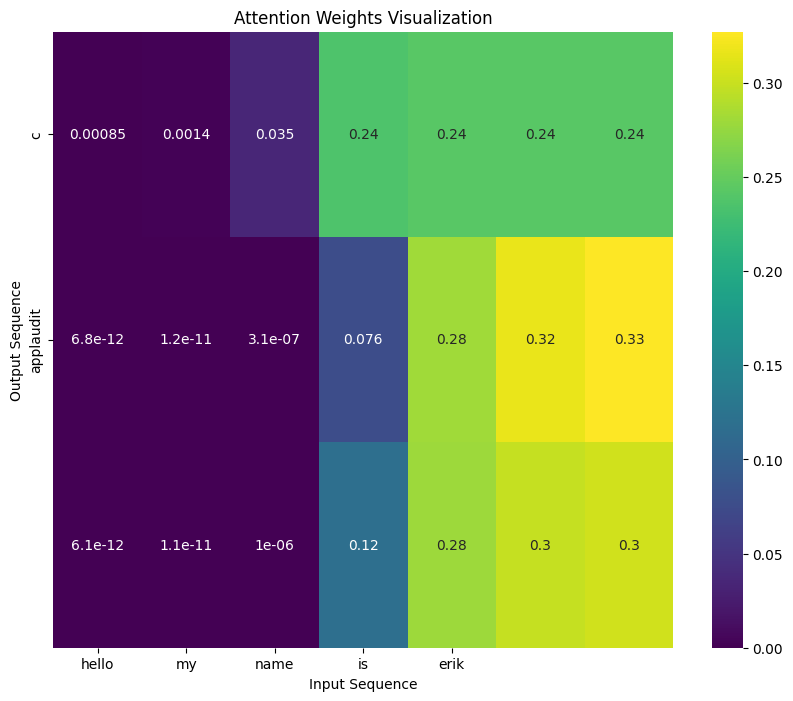

c applaudit


In [600]:
input_text = "hello my name is erik"
translated_text = translate_text(input_text, model, dataset)
print(translated_text)



In [588]:
import numpy as np

# Your original 4D array
attention_weights = np.array(
    [[[[2.6675654e-04],
       [2.8534986e-03],
       [1.2647720e-01],
       [2.8842121e-01],
       [2.9085359e-01],
       [2.9112777e-01]]],

     [[[1.6475365e-12],
       [2.0169423e-11],
       [3.7035430e-04],
       [2.7286166e-01],
       [3.5779631e-01],
       [3.6897168e-01]]],

     [[[1.6858546e-12],
       [2.7380266e-11],
       [1.1753261e-03],
       [2.8819010e-01],
       [3.5121849e-01],
       [3.5941610e-01]]]]
)

# Slicing to remove the last two values from each innermost array
adjusted_weights = attention_weights[:, :, :-2]  # Keep all elements except the last two in the innermost array

# Print the adjusted weights to verify
print(adjusted_weights)

<>:5: SyntaxWarning: list indices must be integers or slices, not list; perhaps you missed a comma?
<>:5: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:13: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:21: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:29: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:37: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:45: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:53: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:61: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:69: SyntaxWarning: list indices must be integers or slices, not float; perhaps you

TypeError: list indices must be integers or slices, not float